# Spectrally Incoherent Array

Another notebook in the series of analysis of Mark's trap array design. 

This notebook explores the effect of Gaussian array generation with polychromatic fields. 

In [1]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

In [2]:
def lorentzian(x, x0, Gamma):
    """Lorentzian function of x, w/ mean x0 and FWHM Gamma"""
    return (1/pi)*(Gamma/2)/((x-x0)**2+(Gamma/2)**2)

## Discretized Field from PSD
Discretize the Lorentzian power spectral density lineshape function, and then use the sqrt amplitude of each PSD amplitude as the field amplitude. We don't know any phase information so just pick a random phase from a flat distribution. 

Text(0, 0.5, 'Amplitude')

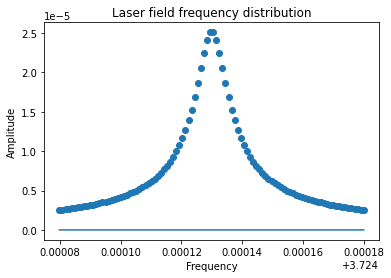

In [12]:
lmbda = 8.05e-7
nu0 = c/lmbda
dnu = 1e9
nu_pts = linspace(nu0-5*dnu,nu0+5*dnu,100)
L = lambda nu: lorentzian(nu, nu0, dnu)
plt.plot(nu_pts/1e14,L(nu_pts))
field_pts = sqrt(L(nu_pts))
plt.scatter(nu_pts/1e14, field_pts)

plt.title(f"Laser field frequency distribution")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

## Fourier propagation
Simulate propagation of the field components through array generator

In [13]:
## physics and lens params

lmbda = 8.05e-7
nu0 = c/lmbda
dnu = 1e12 # full-width half maximum of spectrum
L = lambda nu: lorentzian(nu, nu0, dnu)
k = 2*pi/lmbda

f1 = 1 # lens focal length [m]
f2 = 0.01
A0 = 1 # input field amplitude 

## input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are mm:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are mm:
b=0.004909, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


90 909 90 909


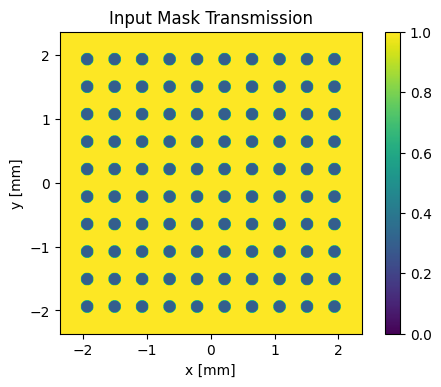

In [19]:
# test the backplate and partially transmitting spots
pts = 1000
r_aper = .7 # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=None, pos_std=None, aperture=1-r_aper, plate=t_plate)

# plot the input field transmission
savefile=False

plt.close()
fig,ax = figax(xlabel=r'x [mm]', ylabel=r'y [mm]')
fig.dpi=100
ax.set_title(rf'Input Mask Transmission') #$t_{{spot}}$={1-r_aper:0.2f}, $t_{{plate}}$={t_plate:0.2f}',)
mmscl = 1e3
cax = ax.imshow(real(mask), extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)
if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

In [15]:
## propagate the field through the system

# input mask
pts = 1000
r_aper = .7 # aperture reflectivity
t_plate = 1 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=None, pos_std=None, aperture=1-r_aper, plate=t_plate)

# generate frequency components
nu_pts = linspace(nu0-5*dnu,nu0+5*dnu,100)
nu_pts.sort()

focal_field = np.zeros(mask.shape,complex)
talbot_field = np.zeros(mask.shape,complex)

# input field 
field0 = mask

# iterate over frequencies
for i,nu in enumerate(nu_pts):
    
    k = 2*pi*nu/c # wave number
    
    #  the field amplitude is the sqrt(power spectral density(nu)) * random phase factor
    field0 = mask*sqrt(L(nu))*exp(-1j*2*pi*rand())
    
    # compute Fourier field, with aperture in Fourier plane
    padding= int(pts/2)
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,padval=1,logging=False)
    
    # output axial planes to evaluate
    for z2 in [f2,f2+zTalbotx]:
        
        # compute output field
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        padding = int(pts/4)
        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,logging=False)
        
        # update the output field
        if z2 == f2:
            focal_field += field2
        else:
            talbot_field += field2
            
    print("Steps completed: ",i+1)
    
I2_focal = conjugate(focal_field)*focal_field
I2_max = amax(I2_focal)
I2_focal /= I2_max
I2_talbot = conjugate(talbot_field)*talbot_field
I2_talbot /= I2_max

90 909 90 909
Steps completed:  1
Steps completed:  2
Steps completed:  3
Steps completed:  4
Steps completed:  5
Steps completed:  6
Steps completed:  7
Steps completed:  8
Steps completed:  9
Steps completed:  10
Steps completed:  11
Steps completed:  12
Steps completed:  13
Steps completed:  14
Steps completed:  15
Steps completed:  16
Steps completed:  17
Steps completed:  18
Steps completed:  19
Steps completed:  20
Steps completed:  21
Steps completed:  22
Steps completed:  23
Steps completed:  24
Steps completed:  25
Steps completed:  26
Steps completed:  27
Steps completed:  28
Steps completed:  29
Steps completed:  30
Steps completed:  31
Steps completed:  32
Steps completed:  33
Steps completed:  34
Steps completed:  35
Steps completed:  36
Steps completed:  37
Steps completed:  38
Steps completed:  39
Steps completed:  40
Steps completed:  41
Steps completed:  42
Steps completed:  43
Steps completed:  44
Steps completed:  45
Steps completed:  46
Steps completed:  47
Steps co

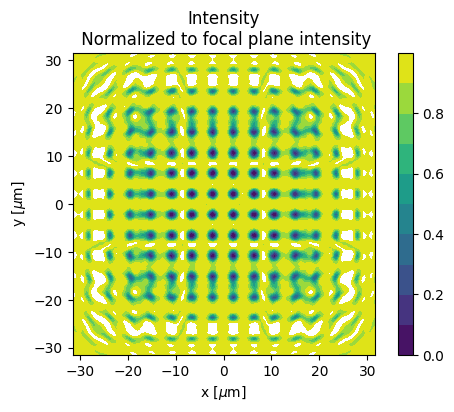

In [23]:
savefile = False
# fname = 


I2 = I2_talbot
# I2 = I2_focal
z2 = f2

scl = 1e6
fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig.dpi=100
title = rf'Intensity'# (z={(z2 - f2)*1e6:0.0f} [$\mu$m])'
title += '\n Normalized to focal plane intensity'
ax.set_title(title)
if f2 - z2 == 0:
    cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2), levels=linspace(0,1,11))
else:
    cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2), levels=linspace(0,1,11))
    cax.set_norm(colors.Normalize(vmin=0, vmax=1))
fig.colorbar(cax, ticks=arange(0,1.0,.2))

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)
    plt.close()

In [ ]:
## analyze slices of the Talbot plane

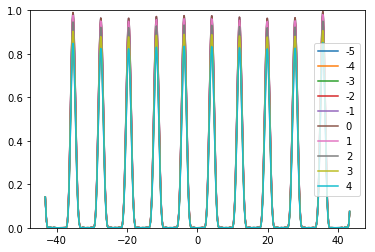

In [221]:
for i in arange(-5,5,1):
    plt.plot(x2pts*scl,ints2[0][:,midpt+39+i],label=i)
# plt.plot(x2pts*scl,ints2[0][:,midpt+39],label=i)
plt.ylim(0,1)
plt.legend()

In [231]:
cvals=['gold','green','orange']
savefile=True

In [237]:
fname = f'bright_I2xz_zcompare_dydx{int(dy/dx*100)}_{xnum}x{ynum}.png'
print(fname)

fig,ax=figax(aspect=None,xlabel=r'$y [\mu m]$',ylabel='Intensity')
for line,label,color in zip(lines,labels,cvals):
    ax.plot(x2pts*scl, line, label=label, color=color)
ax.set_title(f'Intensity2 xz Slices | dy/dx={dy/dx:0.2f}')
ax.set_ylim(0,1)
ax.legend()

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)
savefile = False 

bright_I2xz_zcompare_dydx122_10x10.png
wrote file to bright_I2xz_zcompare_dydx122_10x10.png
